# Stock Sentiment Analysis - Reddit vs the News

## 2. Data Cleaning and Exploratory Analysis

#### Created By: Ben Chamblee - https://github.com/Bench-amblee

### Contents
- [Introduction](#introduction)
- [Imports](#Imports)
- [Load and Consolidate Data](#load-and-consolidate-data)
- [Source Length and Date Analysis](#source-length-and-date-analysis)
- [Text Preprocessing](#text-preprocessing)
- [Sentiment Analysis](#sentiment-analysis)
- [Positive and Negative Word Analysis](#positive-and-negative-word-analysis)
- [Export Data](#export-data)
- [Conclusion and Next Steps](#conclusion-and-next-steps)

<a id="Introduction"></a>
### Introduction

This notebook documents the data cleaning and exploratory data analysis process for this stock sentiment analysis machine learning project. It showcases the methodologies, techniques, and insights used to prepare and understand the raw data before processing for modeling.

The primary objectives of this notebook are to:

- Clean the collected data from Reddit and News Sources
- Handle missing values, duplicates, and outliers in the dataset
- Perform exploratory data analysis to uncover patterns and relationships in 'Magnificent 7' Stocks data
- Visualize key distributions, correlations, and trends
- Document transformation steps for reproducibility
- Validate data quality and consistency after cleaning
- Prepare the final dataset for the processing and modeling

<a id="Imports"></a>
### Imports

In [58]:
import pandas as pd # Data manipulation library providing DataFrame structures
import matplotlib.pyplot as plt # Visualization library for creating graphs
import seaborn as sns # Statistical data visualization based on matplotlib
from datetime import datetime, timedelta # For working with dates and times
import nltk # Natural Language Toolkit for text processing
from nltk.corpus import stopwords # Common words to exclude from analysis
from nltk.tokenize import word_tokenize # Splitting text into individual words
from nltk.stem import PorterStemmer, WordNetLemmatizer # Tools for word normalization
from nltk.sentiment import SentimentIntensityAnalyzer # For sentiment analysis
from collections import Counter # For counting items in collections
from wordcloud import WordCloud # For creating word cloud visualizations
import string # For string manipulation operations
import warnings # For handling warning messages

# Download necessary NLTK resources
nltk.download('punkt') # Tokenizer model
nltk.download('stopwords') # Common words to filter out
nltk.download('wordnet') # Lexical database for lemmatization
nltk.download('vader_lexicon') # Lexicon for sentiment analysis

# Suppress warnings
warnings.filterwarnings('ignore') # Hide warning messages for cleaner output

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Benja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Benja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Benja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<a id="load-and-consolidate-data"></a>
### Load and Consolidate data

We will be loading the data from the previous notebook and consolidating for easier cleaning and analysis.

In [59]:
# Load the data
df = pd.read_csv('../data/magnificent7_data/magnificent7_combined_20250320_101625.csv')

After loading, we'll display basic information about the data and check for missing values

In [60]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Check the first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Check unique values for categorical columns
print("\nUnique platforms:", df['platform'].unique())
print("\nNumber of unique stock symbols:", df['stock_symbol'].nunique())
print("\nUnique stock names:", df['stock_name'].unique())


Dataset shape: (884, 19)

Columns in the dataset:
['platform', 'stock_symbol', 'stock_name', 'post_id', 'title', 'body', 'author', 'score', 'created_at', 'num_comments', 'comments', 'subreddit', 'url', 'search_term', 'collection_time', 'full_text', 'source', 'published_at', 'search_query']

First 5 rows of the dataset:

Missing values in each column:
platform             0
stock_symbol         0
stock_name           0
post_id            492
title                0
body               671
author              34
score              492
created_at         492
num_comments       492
comments           492
subreddit          492
url                  0
search_term        492
collection_time      0
full_text          392
source             392
published_at       392
search_query       392
dtype: int64

Data types:
platform            object
stock_symbol        object
stock_name          object
post_id             object
title               object
body                object
author              ob

Notice that some columns have 492 missing entries and others have 392 missing entries - this likely has something to do with only reddit data being in some columns and only news data being in others. Let's consolidate important data like content and date into joint columns sowe can process both together.

create_consolidated_data takes a dataframe and standardizes it by creating consistent fields across different data sources.

- Creates a consolidated text field by combining title with either body or full_text
- Standardizes date fields from different sources (Reddit and NewsAPI)
- Adds helpful fields for analysis:
    - Content length (character count)
    - Date-only field (without time)
    - Year-month field for temporal aggregation


- Handles potential errors in date parsing with appropriate error handling
- Preserves the original dataframe by working on a copy

In [61]:
# Create a consolidated data source with combined content and standardized date fields.

def create_consolidated_data(df):
    # Make a copy to avoid modifying the original
    data = df.copy()
    
    # Combine title and content (body or full_text)
    data['full_content'] = data['title'].fillna('')
    
    # Add body if it exists
    mask_body = data['body'].notna()
    data.loc[mask_body, 'full_content'] = data.loc[mask_body, 'full_content'] + ' ' + data.loc[mask_body, 'body']
    
    # Add full_text if it exists and body doesn't
    mask_fulltext = data['full_text'].notna() & data['body'].isna()
    data.loc[mask_fulltext, 'full_content'] = data.loc[mask_fulltext, 'full_content'] + ' ' + data.loc[mask_fulltext, 'full_text']
    
    # Create standardized date field - first as string to handle potential format issues
    data['date'] = None
    
    # Use created_at for Reddit posts
    mask_reddit = data['platform'] == 'Reddit'
    # Make sure to handle potential errors in date parsing
    try:
        data.loc[mask_reddit, 'date'] = pd.to_datetime(data.loc[mask_reddit, 'created_at'], errors='coerce')
    except:
        print("Warning: Error parsing Reddit dates. Using string format instead.")
        data.loc[mask_reddit, 'date'] = data.loc[mask_reddit, 'created_at']
    
    # Use published_at for NewsAPI articles
    mask_news = data['platform'] == 'NewsAPI'
    try:
        data.loc[mask_news, 'date'] = pd.to_datetime(data.loc[mask_news, 'published_at'], errors='coerce')
    except:
        print("Warning: Error parsing NewsAPI dates. Using string format instead.")
        data.loc[mask_news, 'date'] = data.loc[mask_news, 'published_at']
    
    # Ensure date is in datetime format
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    
    # Extract just the date part (no time)
    data['date_only'] = data['date'].dt.date
    
    # Add content length feature
    data['content_length'] = data['full_content'].str.len()
    
    # Add year-month field for time aggregations
    data['year_month'] = data['date'].dt.strftime('%Y-%m')
    
    return data

Now let's take a look at our consolidated data to make sure it looks good

In [62]:
# Create consolidated data
consolidated_df = create_consolidated_data(df)

# Check the resulting dataframe
print("\nConsolidated data shape:", consolidated_df.shape)
consolidated_df[['platform', 'stock_symbol', 'stock_name', 'date', 'year_month', 'full_content', 'content_length']].head()


Consolidated data shape: (884, 24)


,platform,stock_symbol,stock_name,date,year_month,full_content,content_length
0,Reddit,GOOGL,Alphabet,2025-03-09 04:28:35,2025-03,"GOOGL is the most bullish ""safe"" stock for lon...",842
1,Reddit,GOOGL,Alphabet,2025-02-27 18:56:30,2025-02,Is Google ($GOOGL) a great long-term buy after...,490
2,Reddit,GOOGL,Alphabet,2025-03-18 08:03:22,2025-03,$GOOG & $GOOGL buy WIZ start up $32 Billion $G...,262
3,Reddit,GOOGL,Alphabet,2025-03-04 17:47:50,2025-03,Waiting to be stimulated GOOGL Let's wait for ...,198
4,Reddit,GOOGL,Alphabet,2024-11-21 17:52:06,2024-11,Why is nobody talking about GOOGL? Yesterday I...,543


Lets see how many posts were collected from each source as well as how many posts reference each of the 7 stocks

In [63]:
# Count posts by platform
platform_counts = consolidated_df['platform'].value_counts()
print(platform_counts)

# Count posts by stock
stock_counts = consolidated_df['stock_name'].value_counts()
print(stock_counts)

platform
NewsAPI    492
Reddit     392
Name: count, dtype: int64
stock_name
Amazon            154
Alphabet          141
Apple             130
Tesla             125
Microsoft         123
Nvidia            109
Meta Platforms    102
Name: count, dtype: int64


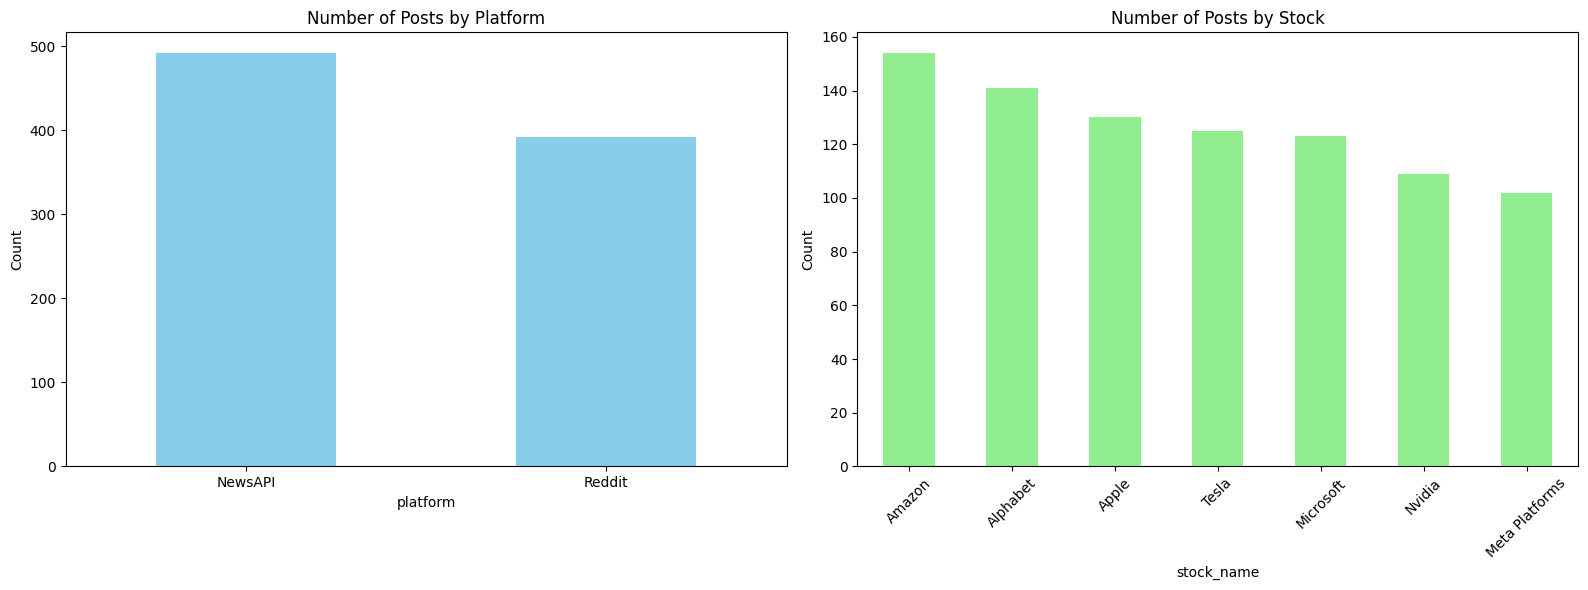

In [64]:
# Visualize the distribution
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
platform_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts by Platform')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
stock_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Posts by Stock')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<a id="source-length-and-date-analysis"></a>
### Source Length and Date Analysis

To get a better sense of the data we've sourced lets take a look and see if we can identify trends in the length of the content (number of characters) or the date when it was published

Let's start with length of content and get a sense of the distribution

In [65]:
# Calculate content length statistics
content_stats = consolidated_df['content_length'].describe()
print(content_stats)

count     884.000000
mean      557.696833
std       792.496243
min         9.000000
25%       249.000000
50%       441.000000
75%       552.000000
max      8177.000000
Name: content_length, dtype: float64


So post content can range from as few as 9 characters to as many as 8177 characters with 558 characters being about average - let's visualize this distribution to get a better idea

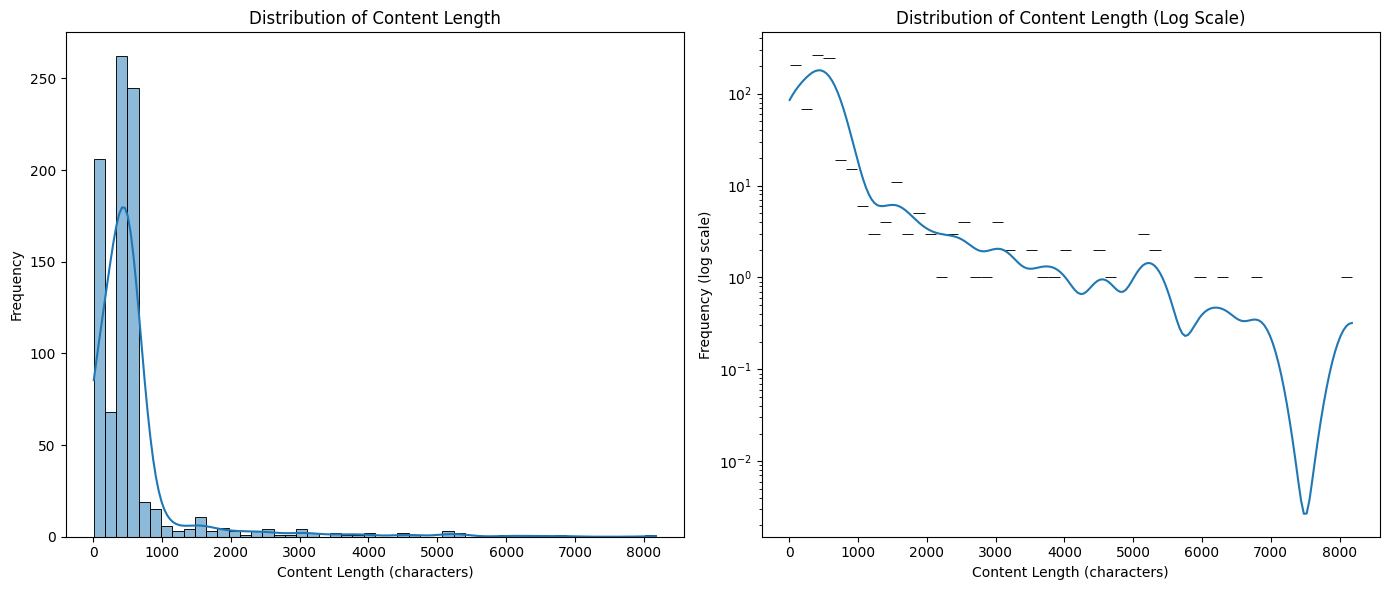

In [66]:
# Visualize the distribution of content length
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(consolidated_df['content_length'], bins=50, kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Log scale to better visualize the distribution
sns.histplot(consolidated_df['content_length'], bins=50, kde=True, log_scale=(False, True))
plt.title('Distribution of Content Length (Log Scale)')
plt.xlabel('Content Length (characters)')
plt.ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

looks like there's a healthy distribution in the middle with a couple of small outliers at the start and end of the distribution - lets take a look at those outliers

In [67]:
min_index = consolidated_df['content_length'].idxmin()
max_index = consolidated_df['content_length'].idxmax()

min_content = consolidated_df.loc[min_index]
max_content = consolidated_df.loc[max_index]

In [68]:
print(min_content['stock_symbol'])
min_content['full_content']

MSFT


'Its alive'

In [69]:
print(max_content['stock_symbol'])
max_content['full_content']

GOOGL


'Apple\'s business is simply an earnings machine. ROC comparison: Apple (23.7%) vs. Alphabet (12.3%) vs. Amazon (5.7%) Source: Apple: Why Recent Underperformance Is A Buying Opportunity Over the last few months, Apple (NASDAQ:AAPL) stock has done something that it doesn\'t often do: underperform. Since the company\'s last earnings call on October 27th, the stock has broken away from the broader market, returning -4% while the S&P 500 (SPY) has delivered 8.5%. The reason for this short-term underperformance isn\'t exactly obvious. Apple, after all, reported record revenues in its October earnings release, and Tim Cook announced that the company has yet to feel the sting of consumer softness in the economy. Investors, however, don\'t seem to have believed him. From worries about production issues in China to softening demand for the iPhone that investors seem certain will materialize at some point, investors just seem plain worried that something will go awry at the world\'s largest comp

It looks like the small one contains no sentiment information so it will naturally be filtered out for the analysis - the larger one though we should remove since it will mess with the analysis. The data is labeling it as Google even though its clearly about Apple and just so happens to mention Google

In [70]:
consolidated_df = consolidated_df.drop(max_index)

Let's see what the stats look like after removing that outlier

count     883.00000
mean      549.06795
std       750.24477
min         9.00000
25%       248.00000
50%       441.00000
75%       552.00000
max      6821.00000
Name: content_length, dtype: float64


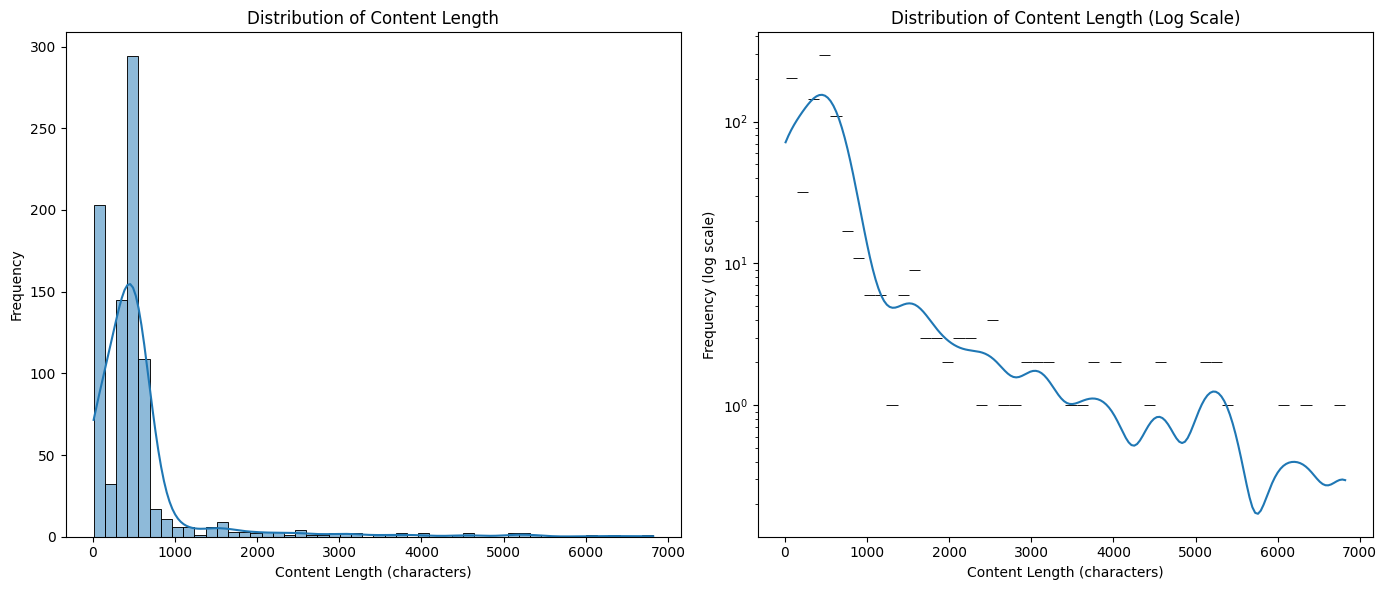

In [71]:
content_stats = consolidated_df['content_length'].describe()
print(content_stats)

# Visualize the distribution of content length
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(consolidated_df['content_length'], bins=50, kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Log scale to better visualize the distribution
sns.histplot(consolidated_df['content_length'], bins=50, kde=True, log_scale=(False, True))
plt.title('Distribution of Content Length (Log Scale)')
plt.xlabel('Content Length (characters)')
plt.ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

Looks much better but lets take one more look a the new largest value just to be sure

In [72]:
max_index = consolidated_df['content_length'].idxmax()
max_content = consolidated_df.loc[max_index]
print(max_content['stock_symbol'])
max_content['full_content']


GOOGL


'Bloomberg: US Considers a Rare Antitrust Move: Breaking Up Google A rare bid to break up Alphabet Inc.’s Google is one of the options being considered by the Justice Department after a landmark court ruling found that the company monopolized the online search market, according to people with knowledge of the deliberations. The move would be Washington’s first push to dismantle a company for illegal monopolization since unsuccessful efforts to break up Microsoft Corp. two decades ago. Less severe options include forcing Google to share more data with competitors and measures to prevent it from gaining an unfair advantage in AI products, said the people, who asked not to be identified discussing private conversations. Regardless, the government will likely seek a ban on the type of exclusive contracts that were at the center of its case against Google. If the Justice Department pushes ahead with a breakup plan, the most likely units for divestment are the Android operating system and Go

This one is about Google and the search term is google - great! let's move on

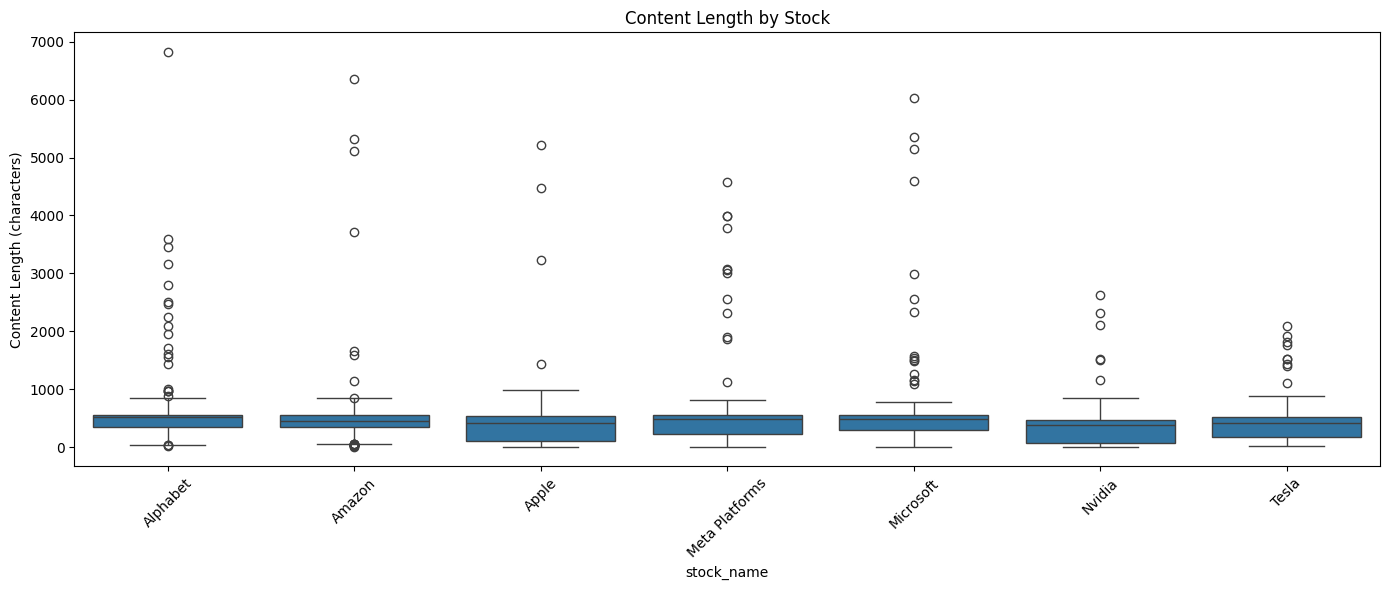

In [73]:
# Compare content length across stocks
plt.figure(figsize=(14, 6))
sns.boxplot(x='stock_name', y='content_length', data=consolidated_df)
plt.title('Content Length by Stock')
plt.xticks(rotation=45)
plt.ylabel('Content Length (characters)')
plt.tight_layout()
plt.show()

As Expected - the data is consolidated towards the bottom, lets filter out posts with a content length above 1000 to see if there's any difference in content length among the 7 stocks

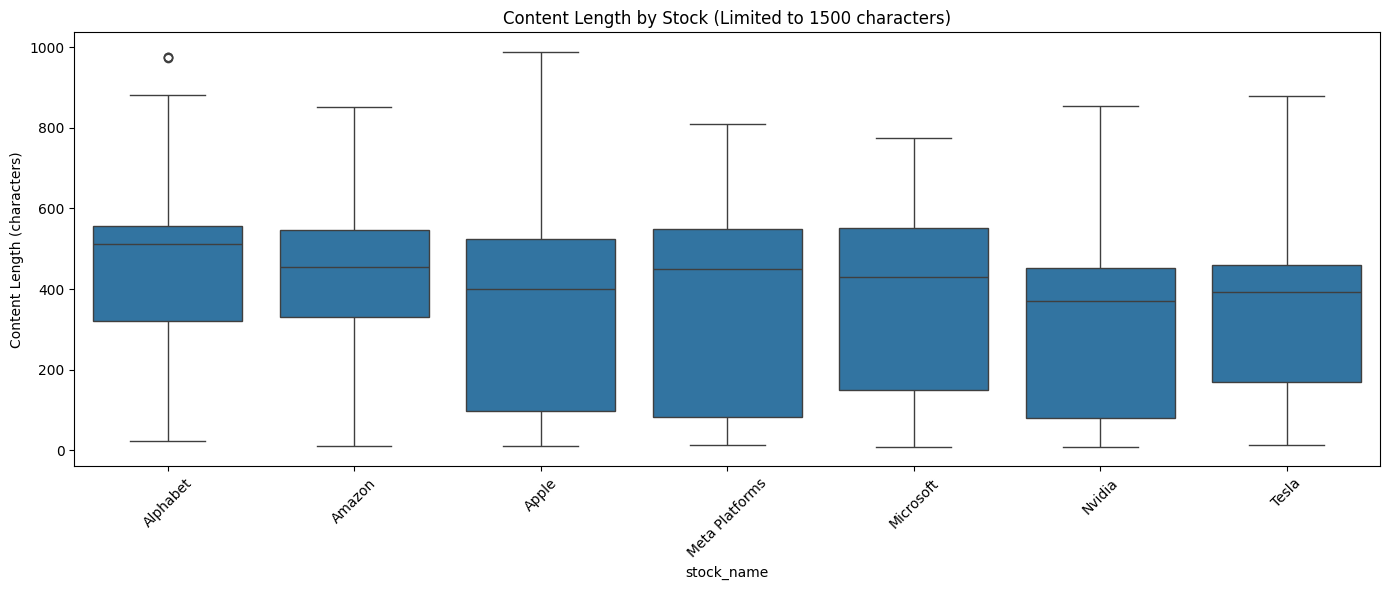

In [74]:
plt.figure(figsize=(14, 6))

# Filter the dataframe to include only rows where content_length is 1000 or less
filtered_df = consolidated_df[consolidated_df['content_length'] <= 1000]

# Create boxplot with filtered data
sns.boxplot(x='stock_name', y='content_length', data=filtered_df)

plt.title('Content Length by Stock (Limited to 1500 characters)')
plt.xticks(rotation=45)
plt.ylabel('Content Length (characters)')
plt.tight_layout()
plt.show()

Looks like Amazon and Google content is typically longer, while Apple and Meta content have the lowest floors within the box plots. In general, most posts are all around the same mean though which means they should all have the same amount of content

Lets move on and look at the dates when these posts were created

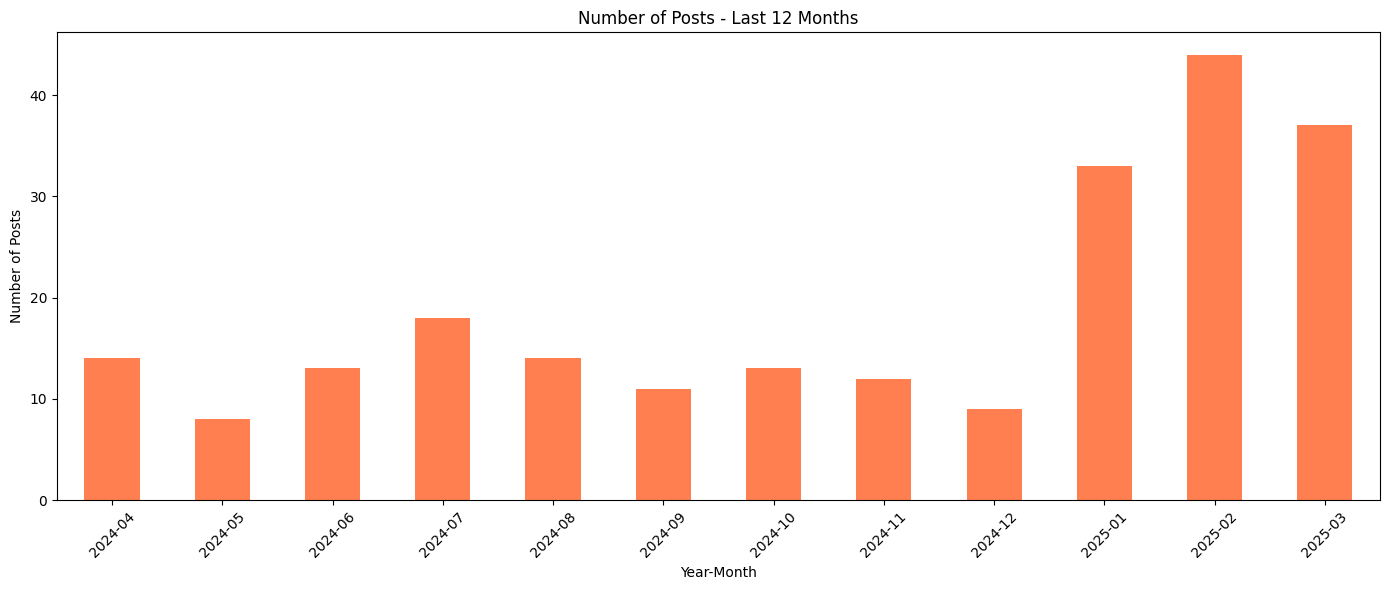

In [75]:
# Let's determine the timeline of the data to understand how far back it goes and the distribution over time.


# Count posts by date
posts_by_date = consolidated_df.groupby('date').size()
posts_by_month = consolidated_df.groupby('year_month').size()

# Focus on the most recent period (last 12 months if available)
recent_months = min(12, len(posts_by_month))
plt.figure(figsize=(14, 6))
posts_by_month.tail(recent_months).plot(kind='bar', color='coral')
plt.title(f'Number of Posts - Last {recent_months} Months')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Great - we've got content for each month over the last year! There's a spike in recent months which makes sense but in general we've got everything covered to analyze the stock's sentiment over the last year.

<a id="text-preprocessing"></a>
### Text Preprocessing

Now that we have cleaned, consolidated, and analyzed the distribution of our data, we can move on to the natural language portion. Lets start looking at the actual content and determine a rough sentiment for each post/platform.

We'll start hte process by removing stop words, including additional stop words that are related to finance but don't provide any real sentiment

In [76]:
# Get stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords related to the domain
custom_stop_words = {
    'stock', 'stocks', 'share', 'shares', 'market', 'markets', 'trading',
    'trade', 'trader', 'traders', 'invest', 'investing', 'investment',
    'investor', 'investors', 'price', 'prices', 'nasdaq',
    'nyse', 'dow', 'jones', 'sp500', 's&p', 'etf', 'etfs', 'fund', 'funds',
    'inc', 'corp', 'corporation', 'company', 'companies', 'llc', 'day',
    'week', 'month', 'year', 'reuters', 'chars'
}

Now we will stem and lemmatize the words (convert words to their base form) to reduce the total amount of unique vocabulary

preprocess_text cleans and normalizes text data to prepare it for natural language processing tasks

- Handles non-text inputs by returning an empty list
- Converts all text to lowercase for consistency
- Removes punctuation marks to focus on word content
- Tokenizes text into individual words
- Filters out common stopwords and single-character terms
- Creates three different versions of the processed text:
    - Basic filtered tokens (stopwords removed)
    - Stemmed tokens (word endings removed)
    - Lemmatized tokens (words converted to base dictionary form)

In [77]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in all_stop_words and len(word) > 1]
    
    # Perform stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Perform lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return {
        'tokens': filtered_tokens,
        'stemmed': stemmed_tokens,
        'lemmatized': lemmatized_tokens
    }


In [78]:
# Combine standard and custom stopwords
all_stop_words = stop_words.union(custom_stop_words)

In [79]:
# Process the text
processed_texts = consolidated_df['full_content'].apply(preprocess_text)

In [80]:
# Extract the processed parts
consolidated_df['tokens'] = processed_texts.apply(lambda x: x['tokens'])
consolidated_df['stemmed'] = processed_texts.apply(lambda x: x['stemmed'])
consolidated_df['lemmatized'] = processed_texts.apply(lambda x: x['lemmatized'])

In [81]:
# Display a sample of the preprocessed text
print("\nSample of preprocessed text:")
for i, row in consolidated_df[['full_content', 'tokens', 'stemmed', 'lemmatized']].head(2).iterrows():
    print(f"\nOriginal: {row['full_content'][:100]}...")
    print(f"Tokens: {row['tokens'][:10]}...")
    print(f"Stemmed: {row['stemmed'][:10]}...")
    print(f"Lemmatized: {row['lemmatized'][:10]}...")


Sample of preprocessed text:

Original: GOOGL is the most bullish "safe" stock for long investors My arguments are the following: \- Alphabe...
Tokens: ['googl', 'bullish', 'safe', 'long', 'arguments', 'following', 'alphabet', 'consecutively', 'beat', 'earnings']...
Stemmed: ['googl', 'bullish', 'safe', 'long', 'argument', 'follow', 'alphabet', 'consecut', 'beat', 'earn']...
Lemmatized: ['googl', 'bullish', 'safe', 'long', 'argument', 'following', 'alphabet', 'consecutively', 'beat', 'earnings']...

Original: Is Google ($GOOGL) a great long-term buy after the recent drop Google (GOOGL) has been dropping quit...
Tokens: ['google', 'googl', 'great', 'longterm', 'buy', 'recent', 'drop', 'google', 'googl', 'dropping']...
Stemmed: ['googl', 'googl', 'great', 'longterm', 'buy', 'recent', 'drop', 'googl', 'googl', 'drop']...
Lemmatized: ['google', 'googl', 'great', 'longterm', 'buy', 'recent', 'drop', 'google', 'googl', 'dropping']...


Great! now that we have consistent vocabulary lets start to look at word frequency to see which non-stop-words appear the most overall and for each stock

get_word_frequencies takes a list of words and uses the Counter library to return a count of each word (token) in the list

In [82]:
# Function to get word frequencies from tokens
def get_word_frequencies(tokens_list):
    all_words = []
    for tokens in tokens_list:
        all_words.extend(tokens)
    return Counter(all_words)

# Get overall word frequencies
all_word_freq = get_word_frequencies(consolidated_df['tokens'])
print("\nMost common words across all stocks:")
print(all_word_freq.most_common(20))


Most common words across all stocks:
[('apple', 354), ('ai', 293), ('tesla', 287), ('microsoft', 257), ('billion', 246), ('alphabet', 232), ('google', 214), ('quarter', 204), ('nvidia', 204), ('new', 195), ('meta', 187), ('report', 183), ('free', 176), ('amazon', 169), ('according', 163), ('us', 162), ('said', 157), ('musk', 129), ('recent', 120), ('elon', 119)]


All the top words make sense, we see our company names and then some buzzwords like 'ai' and 'billion' which lines up with the recent hype in technology and the market in general.

Now lets see if there's any notable words by each company and create a word cloud for each company.


Most common words for Alphabet:
[('alphabet', 220), ('google', 164), ('billion', 116), ('nasdaqgoogl', 96), ('quarter', 77), ('report', 75), ('ai', 73), ('free', 71), ('according', 69), ('search', 58)]

Most common words for Amazon:
[('amazon', 150), ('amazoncom', 58), ('nasdaqamzn', 54), ('amzn', 51), ('new', 38), ('quarter', 38), ('like', 36), ('position', 30), ('according', 29), ('recent', 28)]

Most common words for Apple:
[('apple', 239), ('iphone', 65), ('aapl', 56), ('billion', 47), ('nasdaqaapl', 32), ('new', 31), ('quarter', 30), ('sales', 28), ('report', 27), ('free', 25)]

Most common words for Meta Platforms:
[('meta', 157), ('platforms', 62), ('ai', 55), ('apple', 48), ('technology', 34), ('said', 32), ('us', 29), ('like', 28), ('nvidia', 28), ('nasdaqmeta', 28)]

Most common words for Microsoft:
[('microsoft', 218), ('co', 58), ('nasdaqmsft', 57), ('msft', 54), ('ai', 50), ('report', 48), ('quarter', 45), ('software', 41), ('free', 40), ('new', 33)]

Most common words fo

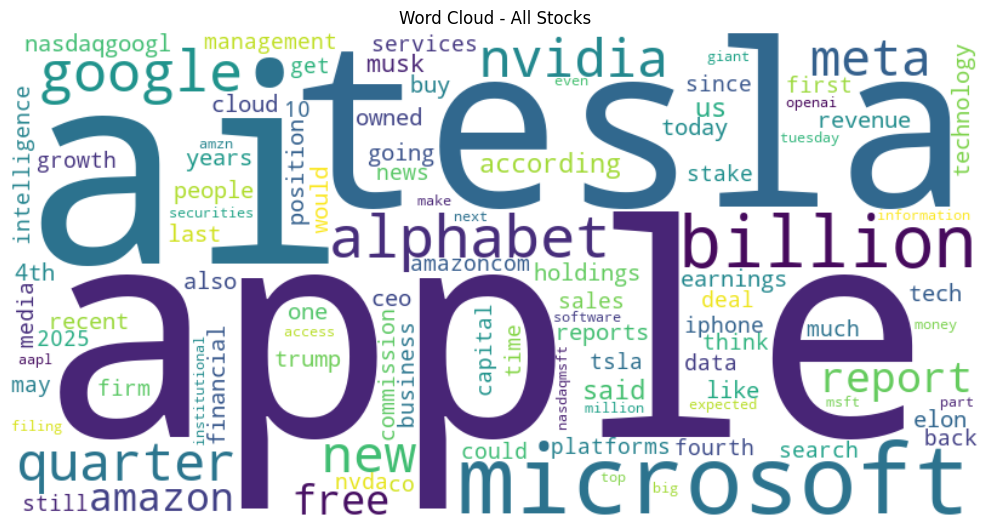

In [83]:
# Get word frequencies by stock
stock_word_freqs = {}
for stock in consolidated_df['stock_name'].unique():
    stock_tokens = consolidated_df[consolidated_df['stock_name'] == stock]['tokens']
    stock_word_freqs[stock] = get_word_frequencies(stock_tokens)
    print(f"\nMost common words for {stock}:")
    print(stock_word_freqs[stock].most_common(10))

# Generate a word cloud for all stocks
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(dict(word_freq))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Generate overall word cloud
plot_wordcloud(all_word_freq, 'Word Cloud - All Stocks')

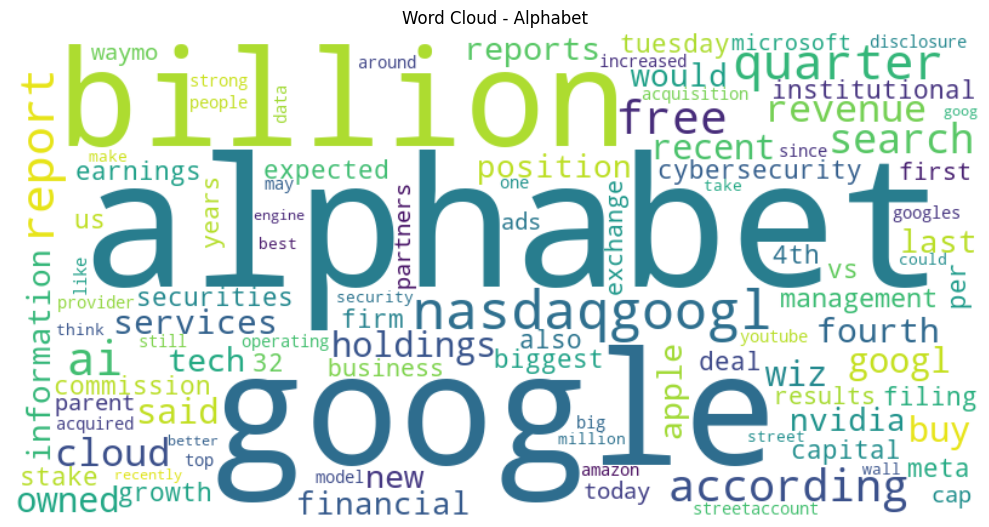

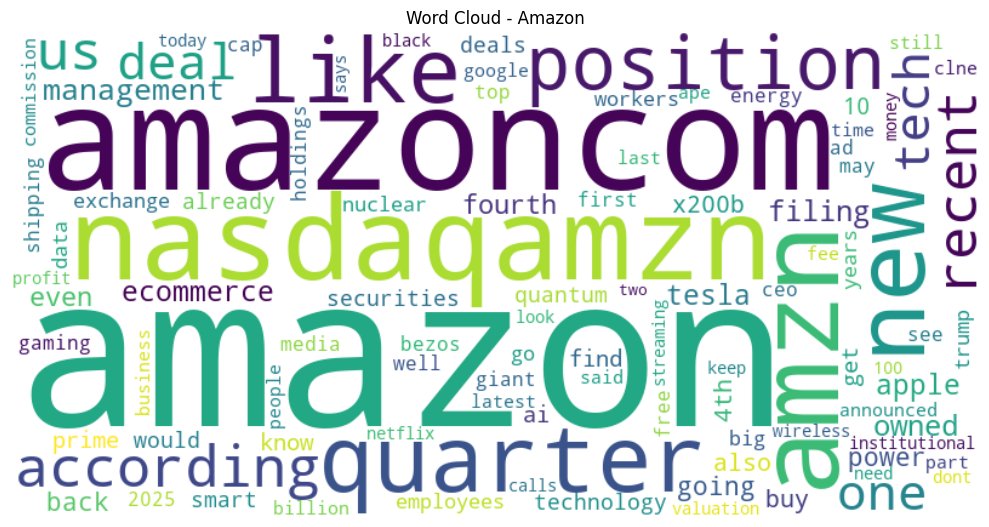

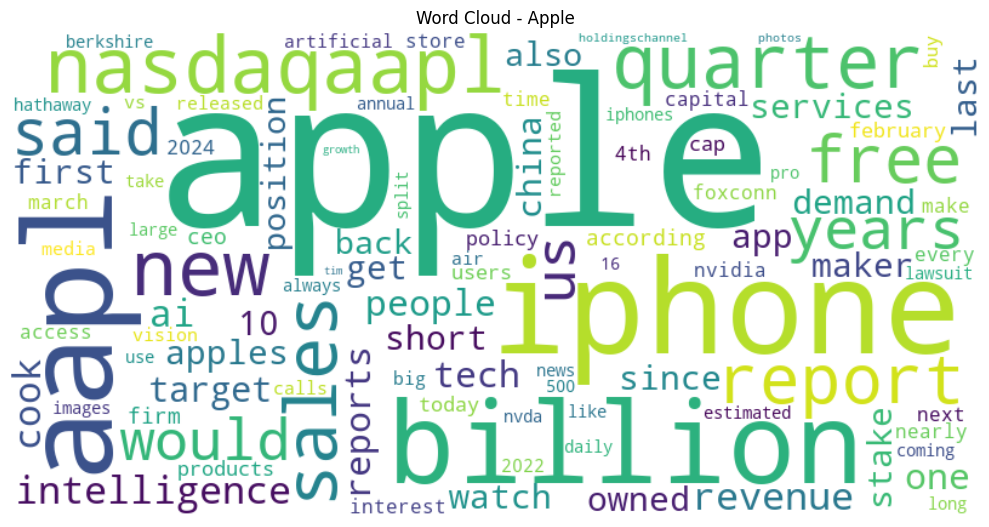

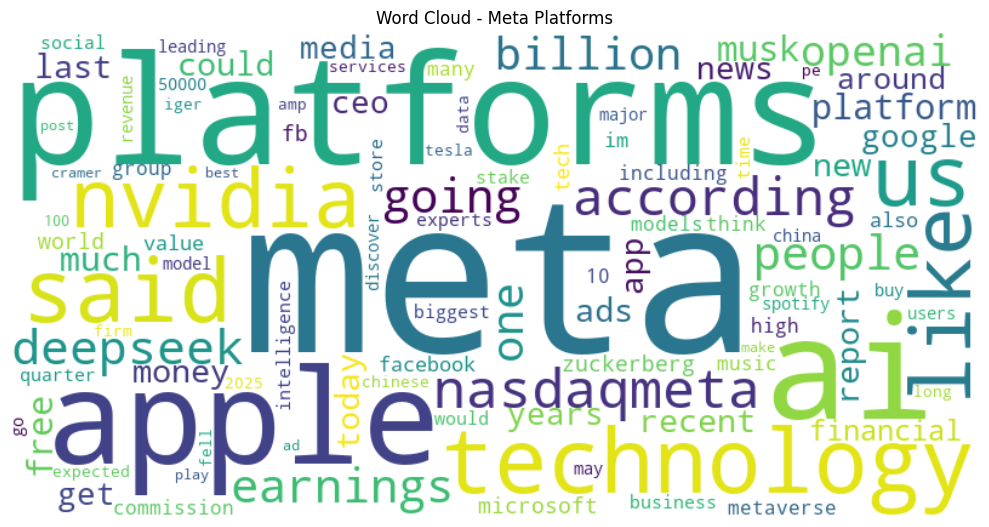

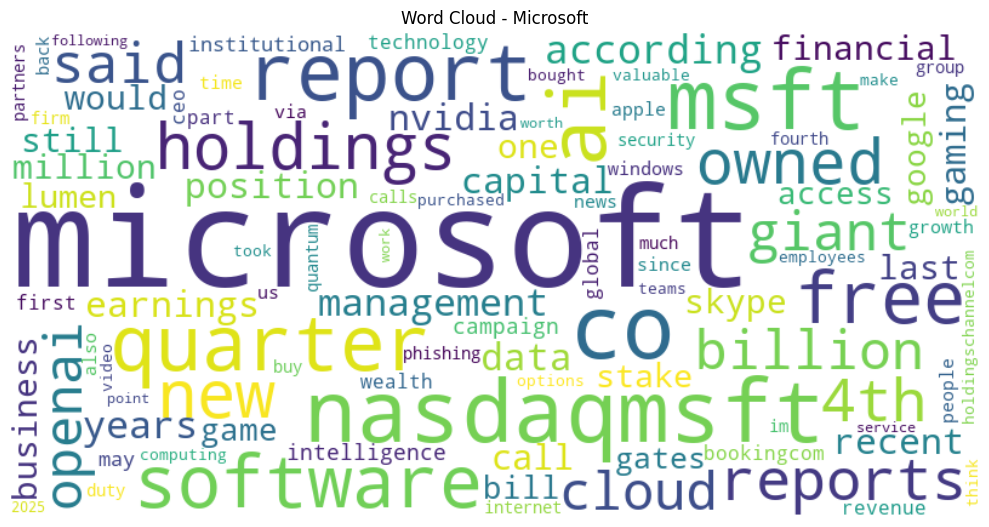

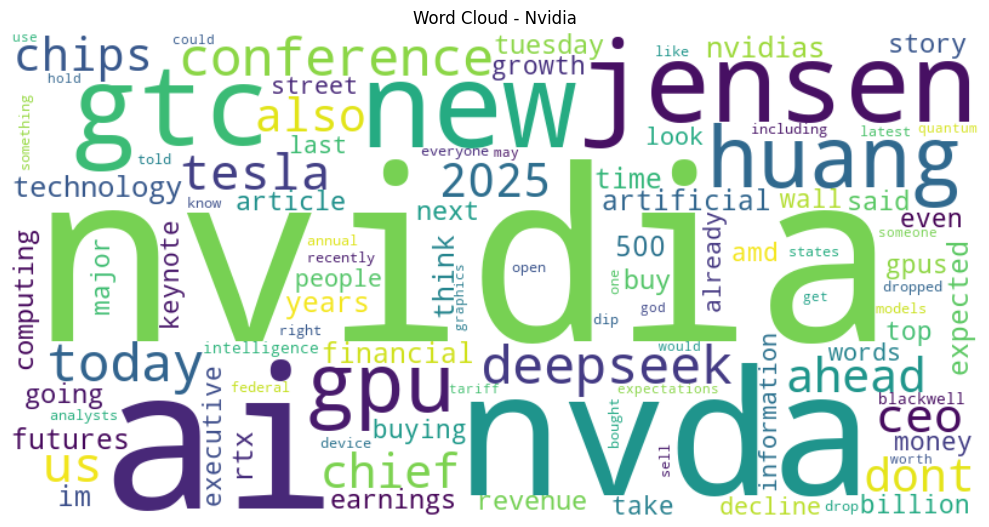

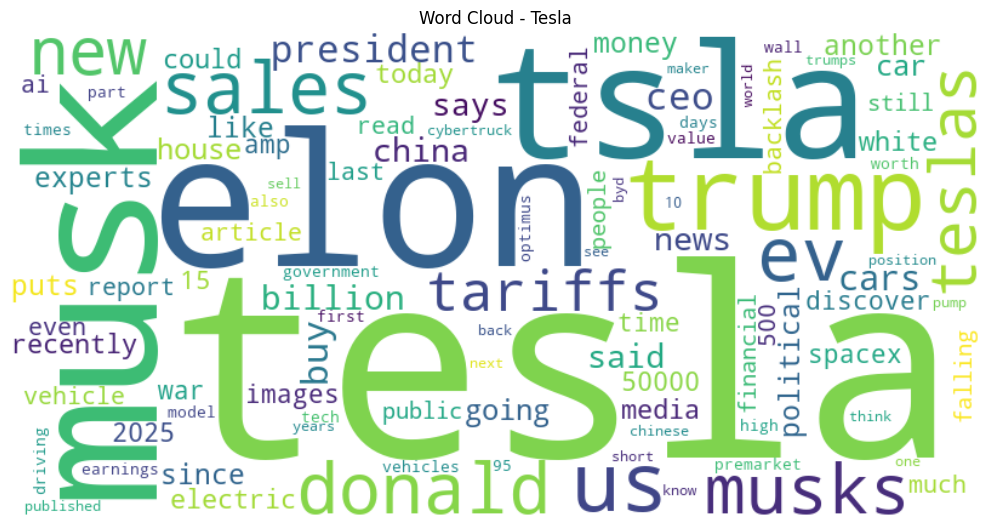

In [84]:
# Generate word clouds for each stock
for stock, word_freq in stock_word_freqs.items():
    plot_wordcloud(word_freq, f'Word Cloud - {stock}')

Some very interesting things in theese word clouds! Lets move on to sentiment analysis

<a id="sentiment-analysis"></a>
### Sentiment Analysis

This portion of the analysis will involve asigning a sentiment value to each post based on the words and their relative meaning. Using NLTK's VADER (Valence Aware Dictionary and sentiment Reasoner) we can asign a numerical value to words like 'good' or 'bad'

get_sentiment returns four numbers
- compound: Overall sentiment score (-1 to +1, where -1 is extremely negative and +1 is extremely positive)
- pos: Proportion of positive sentiment (0 to 1)
- neu: Proportion of neutral sentiment (0 to 1)
- neg: Proportion of negative sentiment (0 to 1)

Based on this score the content will be categorized as either 'Positive' if the compound sentiment is above 0.05, 'Negative' if the compound sentiment is below -0.05, or 'Neutral' if the compound sentiment is between -0.05 and 0.05

In [85]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    if not isinstance(text, str):
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    return sia.polarity_scores(text)

# Add sentiment scores to the dataset
consolidated_df['sentiment'] = consolidated_df['full_content'].apply(get_sentiment)

# Extract sentiment components
consolidated_df['sentiment_compound'] = consolidated_df['sentiment'].apply(lambda x: x['compound'])
consolidated_df['sentiment_positive'] = consolidated_df['sentiment'].apply(lambda x: x['pos'])
consolidated_df['sentiment_neutral'] = consolidated_df['sentiment'].apply(lambda x: x['neu'])
consolidated_df['sentiment_negative'] = consolidated_df['sentiment'].apply(lambda x: x['neg'])

# Categorize sentiment
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

consolidated_df['sentiment_category'] = consolidated_df['sentiment_compound'].apply(categorize_sentiment)

Now that we have our categories lets count them and show the distribution

sentiment_category
Positive    544
Negative    211
Neutral     128
Name: count, dtype: int64


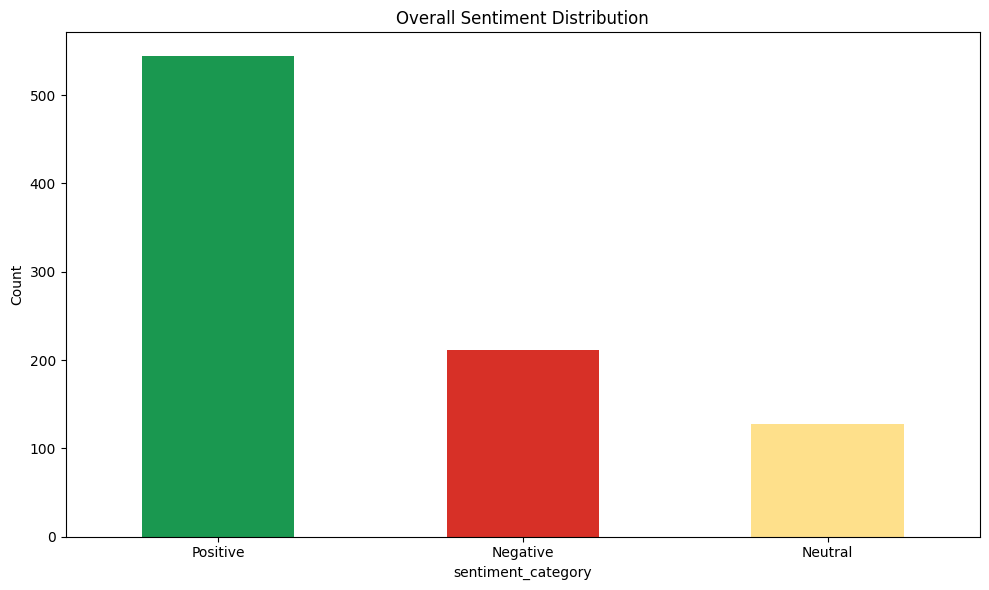

In [86]:
# Count the sentiment categories
sentiment_counts = consolidated_df['sentiment_category'].value_counts()
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
colors = {'Positive': '#1a9850', 'Neutral': '#fee08b', 'Negative': '#d73027'}
sentiment_counts.plot(kind='bar', color=[colors[x] for x in sentiment_counts.index])
plt.title('Overall Sentiment Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Looks like we're mostly positive, lets see if its different by platform

<Figure size 1400x800 with 0 Axes>

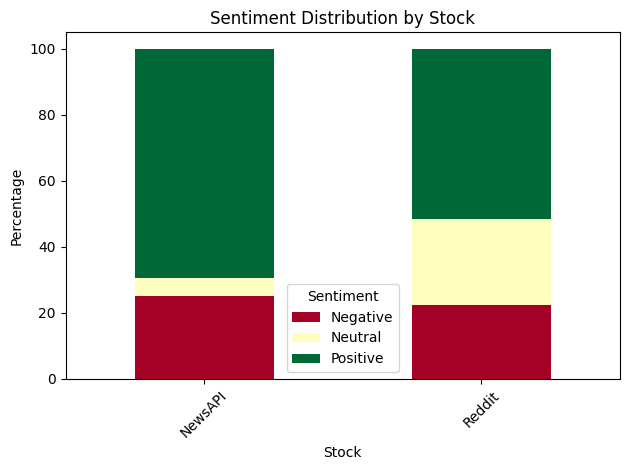

In [87]:
# Calculate sentiment by platform
sentiment_by_stock = consolidated_df.groupby(['platform', 'sentiment_category']).size().unstack(fill_value=0)

# Calculate percentages
sentiment_by_stock_pct = sentiment_by_stock.div(sentiment_by_stock.sum(axis=1), axis=0) * 100

# Visualize sentiment distribution by stock
plt.figure(figsize=(14, 8))
sentiment_by_stock_pct.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Sentiment Distribution by Stock')
plt.ylabel('Percentage')
plt.xlabel('Stock')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Interesting - NewsAPI seems to be much more positive than reddit while reddit seems to be neutral much more than the news

Lets see how this sentiment differs by each stock

<Figure size 1400x800 with 0 Axes>

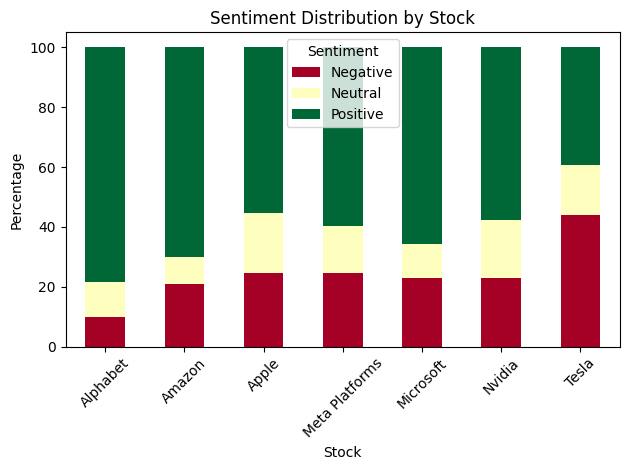

In [88]:
# Calculate sentiment by stock
sentiment_by_stock = consolidated_df.groupby(['stock_name', 'sentiment_category']).size().unstack(fill_value=0)

# Calculate percentages
sentiment_by_stock_pct = sentiment_by_stock.div(sentiment_by_stock.sum(axis=1), axis=0) * 100

# Visualize sentiment distribution by stock
plt.figure(figsize=(14, 8))
sentiment_by_stock_pct.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Sentiment Distribution by Stock')
plt.ylabel('Percentage')
plt.xlabel('Stock')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

As expected, Tesla is the most polarizing stock especially given recent news. It looks like most other stocks have the same distribution, except for Google which is overwhelmingly positive

Let's see what their compound sentiment scores are too

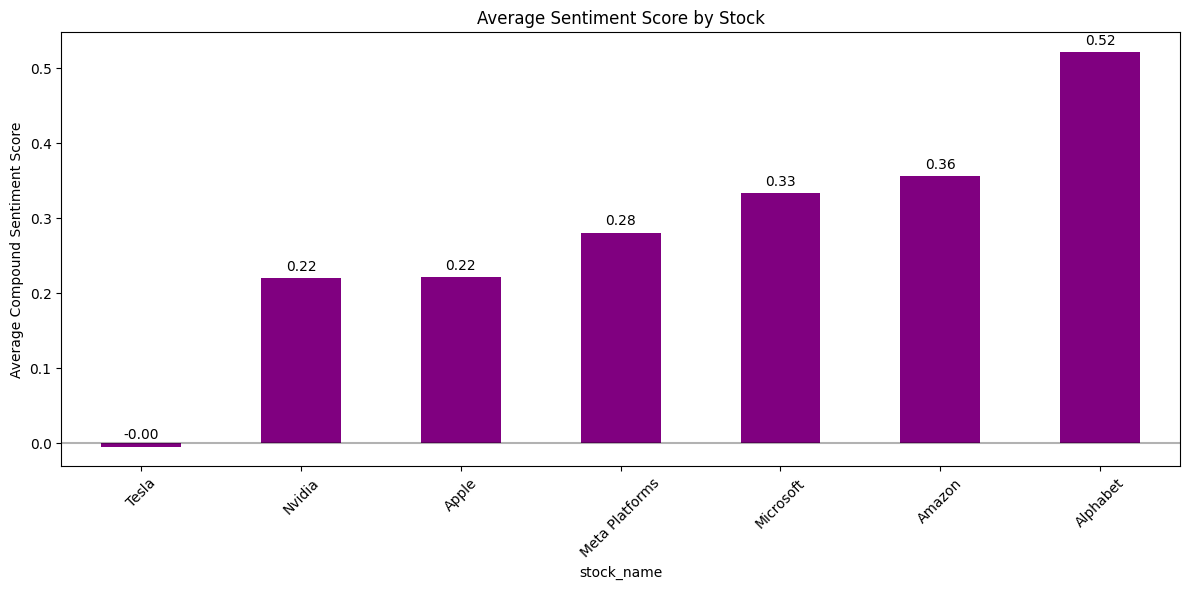

In [89]:
# Calculate average compound sentiment score by stock
avg_sentiment_by_stock = consolidated_df.groupby('stock_name')['sentiment_compound'].mean().sort_values()

plt.figure(figsize=(12, 6))
ax = avg_sentiment_by_stock.plot(kind='bar', color='purple')
plt.title('Average Sentiment Score by Stock')
plt.ylabel('Average Compound Sentiment Score')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(avg_sentiment_by_stock):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center')
    
plt.tight_layout()
plt.show()

This makes sense given the above graph

Let's take a look at the sentiment over time

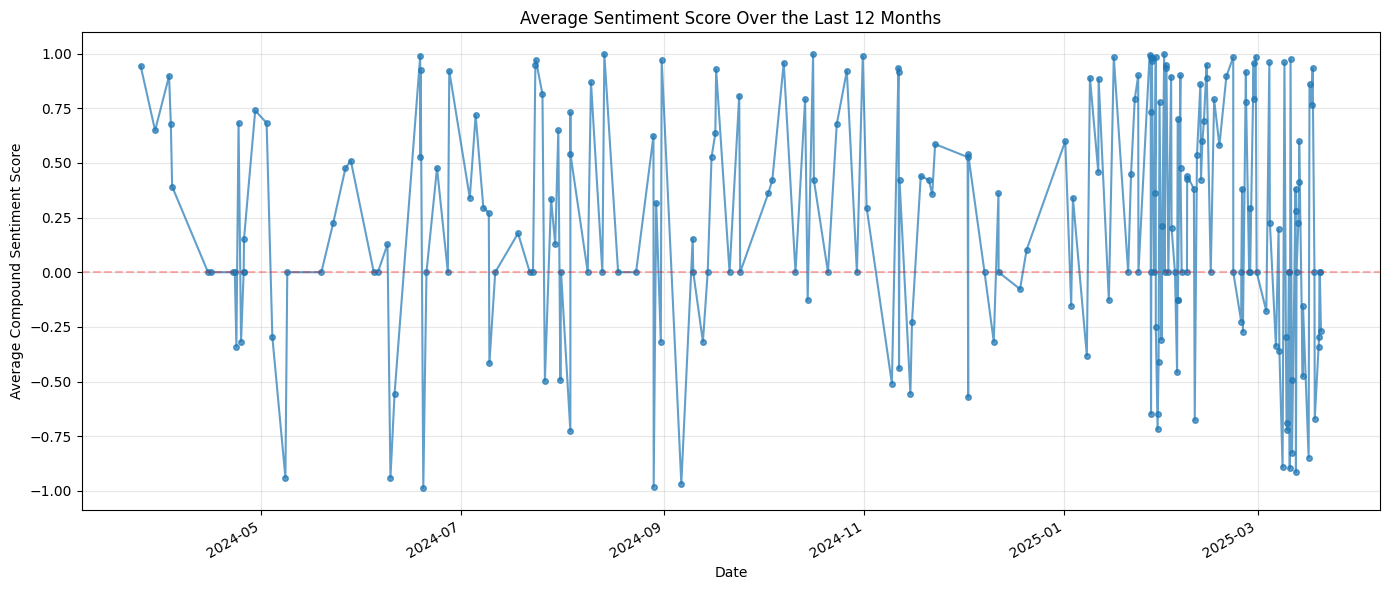

In [90]:
# Convert date column to datetime if it's not already
consolidated_df['date_dt'] = pd.to_datetime(consolidated_df['date'])

# Filter for the last 12 months
one_year_ago = datetime.now() - timedelta(days=365)
filtered_df = consolidated_df[consolidated_df['date_dt'] >= one_year_ago]

# Resample by day and calculate mean sentiment
daily_sentiment = filtered_df.groupby('date_dt')['sentiment_compound'].mean()

# Plot sentiment over time
plt.figure(figsize=(14, 6))
daily_sentiment.plot(linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.title('Average Sentiment Score Over the Last 12 Months')
plt.ylabel('Average Compound Sentiment Score')
plt.xlabel('Date')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

It's difficult to see a real trend here, it looks like sentiment has been all over the place which makes sense sense thats how the stock market is as well

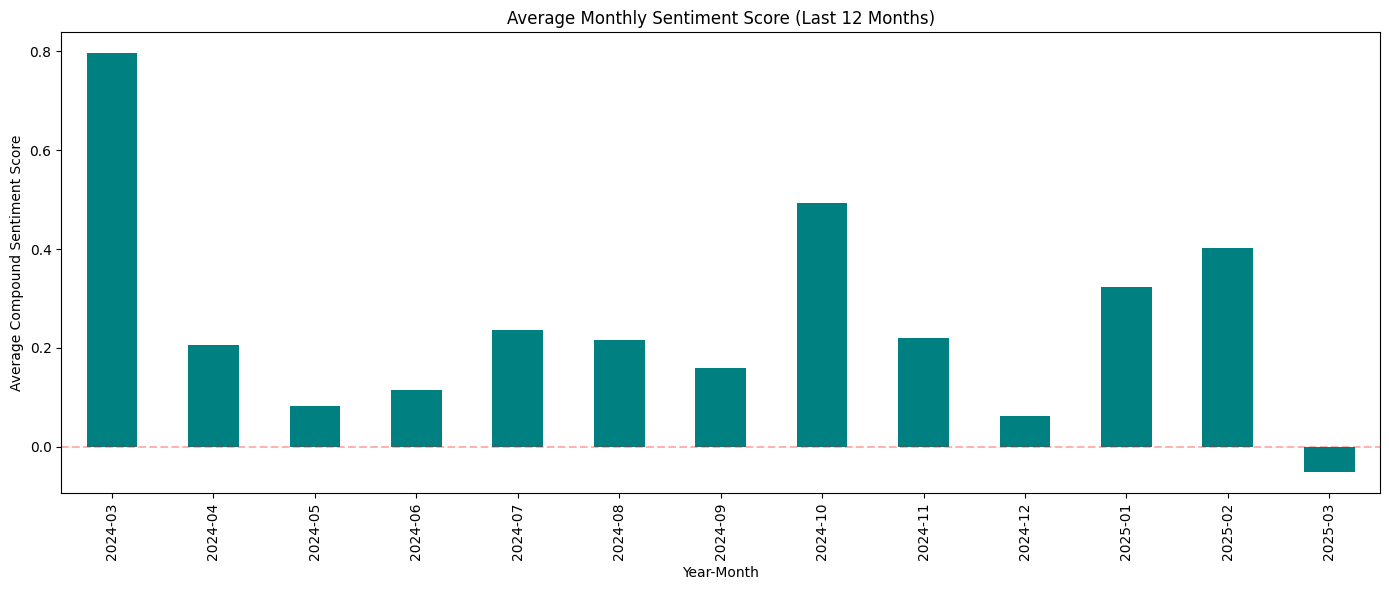

In [91]:
# Extract year and month as a new column
consolidated_df['year_month'] = consolidated_df['date_dt'].dt.to_period('M')

# Filter for the last 12 months
one_year_ago = datetime.now() - timedelta(days=365)
filtered_df = consolidated_df[consolidated_df['date_dt'] >= one_year_ago]

# Group by year_month and calculate mean sentiment
monthly_sentiment = filtered_df.groupby('year_month')['sentiment_compound'].mean()

# Plot monthly sentiment
plt.figure(figsize=(14, 6))
monthly_sentiment.plot(kind='bar', color='teal')
plt.title('Average Monthly Sentiment Score (Last 12 Months)')
plt.ylabel('Average Compound Sentiment Score')
plt.xlabel('Year-Month')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

All positive except for this month!

<a id="positive-and-negative-word-analysis"></a>
### Positive and Negative Word Analysis

The VADER approach we just used words great for general sentiment analysis, but can be limited for content within a specific niche like finance. Words like 'up' and 'down' have complete different meanings so its important to capture those words with their real sentiment by identifying a custom set of positive and negative words.

Let's do that and then show the distribution

count_sentiment_words counts each word (token) and sums up all the words that fall in the 'positive' or 'negative' word list along with counting each total word. It then calculates a score by subtracting the negative count from the positive count and dividing by the total. So if this score is negative that means there were more negative words than positive and vice versa

In [92]:
# ## 9. Positive and Negative Word Analysis
# 
# Let's identify and count positive and negative words in the content.

# Define positive and negative word lists
positive_words = {
    'up', 'rise', 'rising', 'rose', 'increase', 'increased', 'growth', 'grow', 'growing', 
    'positive', 'gain', 'gains', 'profit', 'profits', 'profitable', 'success', 'successful', 
    'strong', 'stronger', 'strength', 'opportunity', 'opportunities', 'potential', 'bullish', 
    'outperform', 'beat', 'beats', 'beating', 'exceed', 'exceeds', 'exceeded', 'higher', 
    'highest', 'record', 'top', 'best', 'better', 'good', 'great', 'excellent', 'amazing', 
    'impressive', 'innovation', 'innovative', 'leading', 'leader', 'recommend', 'buy', 'buying'
}

negative_words = {
    'down', 'fall', 'falling', 'fell', 'decrease', 'decreased', 'decline', 'declining', 
    'negative', 'loss', 'losses', 'bearish', 'weak', 'weaker', 'weakness', 'risk', 'risks', 
    'risky', 'problem', 'problems', 'issue', 'issues', 'concern', 'concerns', 'worried', 'worry', 
    'disappointing', 'disappointed', 'disappointment', 'miss', 'missed', 'missing', 'lower', 
    'lowest', 'poor', 'bad', 'worse', 'worst', 'fail', 'failing', 'failed', 'failure', 
    'underperform', 'sell', 'selling', 'sold', 'avoid', 'avoiding', 'avoided', 'short'
}

# Function to count positive and negative words
def count_sentiment_words(tokens):
    pos_count = sum(1 for token in tokens if token in positive_words)
    neg_count = sum(1 for token in tokens if token in negative_words)
    total = pos_count + neg_count
    
    if total > 0:
        score = (pos_count - neg_count) / total
    else:
        score = 0
        
    return {
        'positive_count': pos_count,
        'negative_count': neg_count,
        'total_sentiment_words': total,
        'sentiment_word_score': score
    }

# Apply the function to the dataset
sentiment_word_counts = consolidated_df['tokens'].apply(count_sentiment_words)

# Extract the counts
consolidated_df['positive_word_count'] = sentiment_word_counts.apply(lambda x: x['positive_count'])
consolidated_df['negative_word_count'] = sentiment_word_counts.apply(lambda x: x['negative_count'])
consolidated_df['total_sentiment_words'] = sentiment_word_counts.apply(lambda x: x['total_sentiment_words'])
consolidated_df['sentiment_word_score'] = sentiment_word_counts.apply(lambda x: x['sentiment_word_score'])

Now that we have scores we can assign categories just like before

In [94]:
# Define our custom sentiment categorization
def word_based_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

consolidated_df['word_sentiment'] = consolidated_df['sentiment_word_score'].apply(word_based_sentiment)

# Count the custom sentiment categories
word_sentiment_counts = consolidated_df['word_sentiment'].value_counts()
print(word_sentiment_counts)

word_sentiment
Neutral     441
Positive    292
Negative    150
Name: count, dtype: int64


This is quite different from our VADER analysis, where most of the posts seemed positive. Let's compare the two methods and see how accurate the VADER method was for financial data


Sentiment method comparison (%):
word_sentiment       Negative    Neutral   Positive
sentiment_category                                 
Negative            28.909953  51.658768  19.431280
Neutral             11.718750  77.343750  10.937500
Positive            13.602941  42.830882  43.566176


<Figure size 1000x600 with 0 Axes>

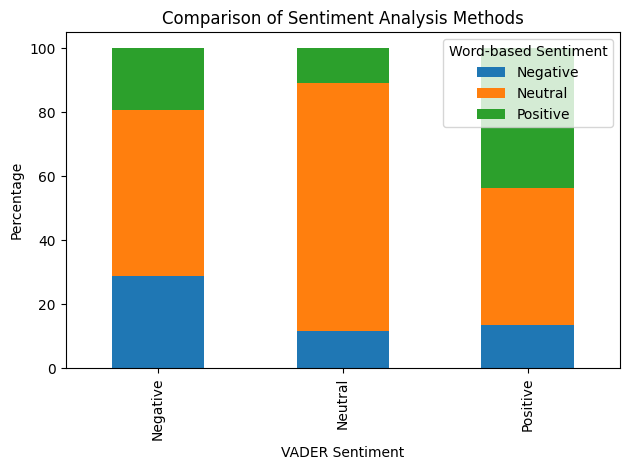

In [96]:
# Compare VADER sentiment with our custom word-based sentiment
# First, add VADER sentiment to the dataframe
consolidated_df['sentiment'] = consolidated_df['full_content'].apply(get_sentiment)
consolidated_df['sentiment_compound'] = consolidated_df['sentiment'].apply(lambda x: x['compound'])
consolidated_df['sentiment_category'] = consolidated_df['sentiment_compound'].apply(categorize_sentiment)

# Create a cross-tabulation
comparison_df = pd.crosstab(
    consolidated_df['sentiment_category'], 
    consolidated_df['word_sentiment'],
    normalize='index'
) * 100

print("\nSentiment method comparison (%):")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', stacked=True)
plt.title('Comparison of Sentiment Analysis Methods')
plt.ylabel('Percentage')
plt.xlabel('VADER Sentiment')
plt.legend(title='Word-based Sentiment')
plt.tight_layout()
plt.show()

This is all over the place - this graph should just be three bars with three different colors but its clear the VADER sentiment and the custom word approach gave some different outputs - it will be interesting to see which one proves to be more useful as we continue and incorporate real stock data

<a id="export-data"></a>
### Export Data

Now lets take our new dataset and add all our sentiment analysis related data to create an export for the next step

In [97]:
# Add all the processing to the full dataset
def process_for_export(df):
    # Create a copy
    processed_df = df.copy()
    
    # Apply sentiment analysis
    processed_df['sentiment'] = processed_df['full_content'].apply(get_sentiment)
    processed_df['sentiment_compound'] = processed_df['sentiment'].apply(lambda x: x['compound'])
    processed_df['sentiment_category'] = processed_df['sentiment_compound'].apply(categorize_sentiment)
    
    # Process text and count sentiment words for all records
    processed_texts = processed_df['full_content'].apply(preprocess_text)
    processed_df['tokens'] = processed_texts.apply(lambda x: x['tokens'])
    processed_df['stemmed'] = processed_texts.apply(lambda x: x['stemmed'])
    processed_df['lemmatized'] = processed_texts.apply(lambda x: x['lemmatized'])
    
    # Count sentiment words
    sentiment_word_counts = processed_df['tokens'].apply(count_sentiment_words)
    processed_df['positive_word_count'] = sentiment_word_counts.apply(lambda x: x['positive_count'])
    processed_df['negative_word_count'] = sentiment_word_counts.apply(lambda x: x['negative_count'])
    processed_df['word_sentiment_score'] = sentiment_word_counts.apply(lambda x: x['sentiment_word_score'])
    processed_df['word_sentiment'] = processed_df['word_sentiment_score'].apply(word_based_sentiment)
    
    # Select columns for export
    export_df = processed_df[[
        'platform', 'stock_symbol', 'stock_name', 'date', 'year_month',
        'full_content', 'content_length', 
        'sentiment_compound', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative',
        'sentiment_category', 'positive_word_count', 'negative_word_count', 
        'word_sentiment_score', 'word_sentiment'
    ]]
    
    return export_df

# Process the full dataset
export_df = process_for_export(consolidated_df)

Finally we can save the data to our output directory

In [188]:
export_df.to_csv('../data/magnificent7_data/magnificent7_processed_data.csv', index=False)

<a id="conclusion-and-next-steps"></a>
### Conclusion and Next Steps

This notebook successfully cleans, consolidates, and analyzes the data gathered from the previous notebook. Using NLTK we have created and initial sentiment analysis using VADER and a custom word-based approach. We have initially distributions for company and platform sentiment and are ready to incorporate the data with real stock data for a comparison.

#### Next Steps

Processing

- Source stock return data for the past year
- Use Reddit and the News' sentiment to create predictions for each stock for a whole year
- Compare this prediction to actual returns to establsih a baseline
- Transform data for modeling purposes and establish which features are most important

The processing step will prepare our data to be turned into a machine learning model and will give us a good baseline idea of how well the sentiment data matches up with actual returns